# Dermatologist-AI Project: Single Network Approach
Workbook for a single network approach that classifies images into melanomas, nevus, or SBK

### Set up and process data

In [21]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from keras.preprocessing import image                  
from tqdm import tqdm
from PIL import ImageFile                            
import os
import pickle
ImageFile.LOAD_TRUNCATED_IMAGES = True      


# define function to load train, test, and validation datasets
def load_dataset(path, shuffle):
    data = load_files(path, shuffle=shuffle)
    file_paths = np.array(data['filenames'])
    one_hot_labels = np_utils.to_categorical(np.array(data['target']),3)
    return file_paths, one_hot_labels

# define functions to convert images into 4D tensors for convnets
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors) 

# define function to decide whether to load tensors from a saved pickle or raw images
def load_tensors_and_labels(pickle_file, raw_file_path, shuffle, force=False):
    pickle_file = os.path.join('.', pickle_file)
 
    if force or not os.path.exists(pickle_file):
        files, labels = load_dataset(raw_file_path, shuffle)
        tensors = paths_to_tensor(files).astype('float32')/255
        with open(pickle_file, 'wb') as handle:
            pickle.dump([tensors, labels], handle, protocol=pickle.HIGHEST_PROTOCOL)
        return tensors, labels

    else:        
        with open(pickle_file, 'rb') as handle:
            tensors, labels = pickle.load(handle)        
        return tensors, labels
    

In [32]:
# Load data

train_tensors, train_labels = load_tensors_and_labels('train_data.pickle','../data/train', True)
valid_tensors, valid_labels = load_tensors_and_labels('valid_data.pickle','../data/valid', True)
test_tensors, test_labels = load_tensors_and_labels('test_data.pickle','../data/test', False)

# load list of skin condition names
skin_names = [item[14:-1] for item in sorted(glob("../data/train/*/"))]


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [03:19<00:00, 11.11it/s]


In [33]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=48, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=48, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=48, kernel_size=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 224, 224, 32)      1056      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 112, 112, 48)      13872     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 112, 112, 48)      20784     
__________

In [34]:
from keras import optimizers
opt = optimizers.rmsprop(lr=0.00005, decay=1e-6)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
from keras.callbacks import ModelCheckpoint  

epochs = 50

checkpointer = ModelCheckpoint(filepath='saved_models/weights1.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_labels,
            validation_data=(valid_tensors, valid_labels),
            epochs=epochs,
            batch_size=20,
            callbacks=[checkpointer],
            verbose=1)

Train on 2000 samples, validate on 150 samples
Epoch 1/50
2000/2000 [==============================] - 34s - loss: 0.8439 - acc: 0.6840 - val_loss: 1.0408 - val_acc: 0.5200
Epoch 2/50
2000/2000 [==============================] - 34s - loss: 0.8326 - acc: 0.6860 - val_loss: 1.0385 - val_acc: 0.5200
Epoch 3/50


2000/2000 [==============================] - 34s - loss: 0.8255 - acc: 0.6860 - val_loss: 1.0408 - val_acc: 0.5200
Epoch 4/50
2000/2000 [==============================] - 34s - loss: 0.8198 - acc: 0.6860 - val_loss: 1.0529 - val_acc: 0.5200
Epoch 5/50


2000/2000 [==============================] - 34s - loss: 0.8177 - acc: 0.6860 - val_loss: 1.0571 - val_acc: 0.5200
Epoch 6/50
2000/2000 [==============================] - 34s - loss: 0.8100 - acc: 0.6860 - val_loss: 1.0330 - val_acc: 0.5200
Epoch 7/50


2000/2000 [==============================] - 34s - loss: 0.8075 - acc: 0.6860 - val_loss: 1.0355 - val_acc: 0.5200
Epoch 8/50
2000/2000 [==============================] - 34s - loss: 0.8013 - acc: 0.6860 - val_loss: 1.0114 - val_acc: 0.5200
Epoch 9/50


2000/2000 [==============================] - 34s - loss: 0.7875 - acc: 0.6860 - val_loss: 0.9955 - val_acc: 0.5200
Epoch 10/50
2000/2000 [==============================] - 33s - loss: 0.7837 - acc: 0.6860 - val_loss: 0.9863 - val_acc: 0.5200
Epoch 11/50


2000/2000 [==============================] - 33s - loss: 0.7703 - acc: 0.6860 - val_loss: 0.9691 - val_acc: 0.5200
Epoch 12/50
2000/2000 [==============================] - 33s - loss: 0.7714 - acc: 0.6860 - val_loss: 0.9747 - val_acc: 0.5200
Epoch 13/50


2000/2000 [==============================] - 33s - loss: 0.7617 - acc: 0.6860 - val_loss: 0.9458 - val_acc: 0.5200
Epoch 14/50
2000/2000 [==============================] - 33s - loss: 0.7532 - acc: 0.6860 - val_loss: 0.9284 - val_acc: 0.5200
Epoch 15/50


2000/2000 [==============================] - 33s - loss: 0.7522 - acc: 0.6860 - val_loss: 0.9103 - val_acc: 0.5200
Epoch 16/50
2000/2000 [==============================] - 33s - loss: 0.7464 - acc: 0.6865 - val_loss: 0.9136 - val_acc: 0.5200
Epoch 17/50


2000/2000 [==============================] - 33s - loss: 0.7421 - acc: 0.6870 - val_loss: 0.9050 - val_acc: 0.5267
Epoch 18/50
2000/2000 [==============================] - 33s - loss: 0.7353 - acc: 0.6890 - val_loss: 0.9118 - val_acc: 0.5800
Epoch 19/50


2000/2000 [==============================] - 33s - loss: 0.7395 - acc: 0.6915 - val_loss: 0.8953 - val_acc: 0.5267
Epoch 20/50
2000/2000 [==============================] - 33s - loss: 0.7280 - acc: 0.6915 - val_loss: 0.9003 - val_acc: 0.5667
Epoch 21/50


2000/2000 [==============================] - 33s - loss: 0.7254 - acc: 0.6915 - val_loss: 0.9105 - val_acc: 0.6000
Epoch 22/50
2000/2000 [==============================] - 33s - loss: 0.7204 - acc: 0.6955 - val_loss: 0.9066 - val_acc: 0.6000
Epoch 23/50


2000/2000 [==============================] - 33s - loss: 0.7248 - acc: 0.6905 - val_loss: 0.8836 - val_acc: 0.5733
Epoch 24/50
2000/2000 [==============================] - 33s - loss: 0.7173 - acc: 0.6930 - val_loss: 0.8738 - val_acc: 0.5933
Epoch 25/50


2000/2000 [==============================] - 33s - loss: 0.7142 - acc: 0.6980 - val_loss: 0.8885 - val_acc: 0.5733
Epoch 26/50
2000/2000 [==============================] - 33s - loss: 0.7057 - acc: 0.6980 - val_loss: 0.8825 - val_acc: 0.6000
Epoch 27/50


2000/2000 [==============================] - 33s - loss: 0.7053 - acc: 0.7015 - val_loss: 0.8575 - val_acc: 0.6067
Epoch 28/50
2000/2000 [==============================] - 33s - loss: 0.6927 - acc: 0.7040 - val_loss: 0.8969 - val_acc: 0.5333
Epoch 29/50


2000/2000 [==============================] - 33s - loss: 0.6944 - acc: 0.7000 - val_loss: 0.8559 - val_acc: 0.6000
Epoch 30/50
2000/2000 [==============================] - 33s - loss: 0.6981 - acc: 0.7095 - val_loss: 0.8503 - val_acc: 0.5867
Epoch 31/50


2000/2000 [==============================] - 33s - loss: 0.6926 - acc: 0.7060 - val_loss: 0.8669 - val_acc: 0.6200
Epoch 32/50
2000/2000 [==============================] - 33s - loss: 0.6922 - acc: 0.7085 - val_loss: 0.8339 - val_acc: 0.6133
Epoch 33/50


2000/2000 [==============================] - 33s - loss: 0.6959 - acc: 0.7085 - val_loss: 0.8473 - val_acc: 0.6067
Epoch 34/50
2000/2000 [==============================] - 33s - loss: 0.6865 - acc: 0.7110 - val_loss: 0.8641 - val_acc: 0.5733
Epoch 35/50


2000/2000 [==============================] - 33s - loss: 0.6787 - acc: 0.7130 - val_loss: 0.8278 - val_acc: 0.5800
Epoch 36/50
2000/2000 [==============================] - 35s - loss: 0.6767 - acc: 0.7210 - val_loss: 0.8384 - val_acc: 0.5733
Epoch 37/50


2000/2000 [==============================] - 34s - loss: 0.6777 - acc: 0.7145 - val_loss: 0.8223 - val_acc: 0.6200
Epoch 38/50
2000/2000 [==============================] - 34s - loss: 0.6803 - acc: 0.7160 - val_loss: 0.8364 - val_acc: 0.6333
Epoch 39/50


2000/2000 [==============================] - 34s - loss: 0.6807 - acc: 0.7125 - val_loss: 0.8442 - val_acc: 0.6267
Epoch 40/50
2000/2000 [==============================] - 34s - loss: 0.6710 - acc: 0.7230 - val_loss: 0.8109 - val_acc: 0.6133
Epoch 41/50


2000/2000 [==============================] - 34s - loss: 0.6700 - acc: 0.7190 - val_loss: 0.8364 - val_acc: 0.6200
Epoch 42/50
2000/2000 [==============================] - 45s - loss: 0.6677 - acc: 0.7245 - val_loss: 0.7992 - val_acc: 0.6133
Epoch 43/50


2000/2000 [==============================] - 36s - loss: 0.6560 - acc: 0.7230 - val_loss: 0.8040 - val_acc: 0.6133
Epoch 44/50
2000/2000 [==============================] - 37s - loss: 0.6592 - acc: 0.7225 - val_loss: 0.7909 - val_acc: 0.6067
Epoch 45/50


2000/2000 [==============================] - 36s - loss: 0.6590 - acc: 0.7235 - val_loss: 0.8121 - val_acc: 0.6267
Epoch 46/50
2000/2000 [==============================] - 42s - loss: 0.6557 - acc: 0.7225 - val_loss: 0.8278 - val_acc: 0.6067
Epoch 47/50


2000/2000 [==============================] - 50s - loss: 0.6557 - acc: 0.7255 - val_loss: 0.7854 - val_acc: 0.6133
Epoch 48/50
2000/2000 [==============================] - 35s - loss: 0.6495 - acc: 0.7265 - val_loss: 0.7966 - val_acc: 0.6267
Epoch 49/50


2000/2000 [==============================] - 35s - loss: 0.6426 - acc: 0.7225 - val_loss: 0.7967 - val_acc: 0.6400
Epoch 50/50
2000/2000 [==============================] - 35s - loss: 0.6548 - acc: 0.7235 - val_loss: 0.8097 - val_acc: 0.6333


## Create output .csv for testing

In [36]:
# Load the model weights with the best validation loss.

model.load_weights('saved_models/weights1.hdf5')

In [38]:
import pandas as pd

y_pred = pd.DataFrame(columns=["task_1", "task_2"])

for ii in tqdm(range(len(test_files))):
    path = test_files[ii]
    prediction = np.argmax(model.predict(np.expand_dims(test_tensors[ii], axis=0)))
    if prediction == 0:
        y_pred.loc[path] = [1, 0]
    if prediction == 2:
        y_pred.loc[path] = [0, 1]
    else:
        y_pred.loc[path] = [0, 0]

y_pred.to_csv("predictions.csv")

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:11<00:00, 51.09it/s]


## Internal testing vs. ground truths

In [39]:
import itertools
import keras
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_curve, auc, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator

def plot_roc_auc(y_true, y_pred):
    """
    This function plots the ROC curves and provides the scores.
    """

    # initialize dictionaries and array
    fpr = dict()
    tpr = dict()
    roc_auc = np.zeros(3)
    
    # prepare for figure
    plt.figure()
    colors = ['aqua', 'cornflowerblue']

    # for both classification tasks (categories 1 and 2)
    for i in range(2):
        # obtain ROC curve
        fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_pred[:,i])
        # obtain ROC AUC
        roc_auc[i] = auc(fpr[i], tpr[i])
        # plot ROC curve
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label='ROC curve for task {d} (area = {f:.2f})'.format(d=i+1, f=roc_auc[i]))
    # get score for category 3
    roc_auc[2] = np.average(roc_auc[:2])
    
    # format figure
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()
    
    # print scores
    for i in range(3):
        print('Category {d} Score: {f:.3f}'. format(d=i+1, f=roc_auc[i]))

def plot_confusion_matrix(y_true, y_pred, thresh, classes):
    """
    This function plots the (normalized) confusion matrix.
    """

    # obtain class predictions from probabilities
    y_pred = (y_pred>=thresh)*1
    # obtain (unnormalized) confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

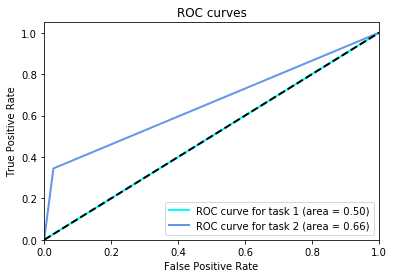

Category 1 Score: 0.500
Category 2 Score: 0.658
Category 3 Score: 0.579


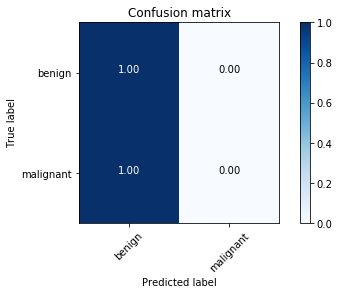

In [40]:
preds_path = sys.argv[1]
thresh = 0.5

# get ground truth labels for test dataset
truth = pd.read_csv('ground_truth.csv')
y_true = truth.as_matrix(columns=["task_1", "task_2"])

# get model predictions for test dataset
y_pred = pd.read_csv("predictions.csv")
y_pred = y_pred.as_matrix(columns=["task_1", "task_2"])

# plot ROC curves and print scores
plot_roc_auc(y_true, y_pred)
# plot confusion matrix
classes = ['benign', 'malignant']
plot_confusion_matrix(y_true[:,0], y_pred[:,0], thresh, classes)
